In [17]:
import unittest

import numpy
import pandas
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm
import statsmodels.api as sm
from matplotlib.pyplot import figure
from datetime import date, timedelta
from typing import List, Tuple
from math import exp, log, sqrt
import os
import io

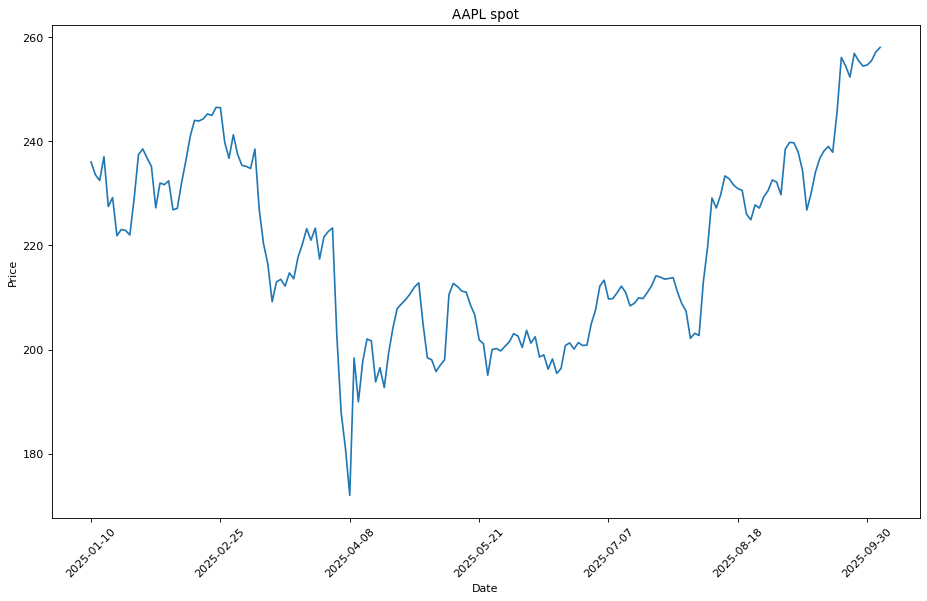

In [18]:
underlying = "AAPL"

indexValues = pandas.read_csv('data/AAPL.csv')
indexDates = indexValues['Date'].to_list()
# indexValues = indexValues.set_index("Date", drop=True)
quotes = indexValues["underlyingPrice"]

figure(figsize=(14, 8), dpi=80)

plt.plot(indexValues["underlyingPrice"])
plt.title(f"{underlying} spot")
plt.xlabel("Date")
plt.ylabel("Price")

step = 30
positions = range(0, len(indexDates), step)
labels = [indexDates[i] for i in positions]

plt.xticks(ticks=positions, labels=labels, rotation=45)
plt.show()

# Task 1: Pricing - 1 point

1. Implement the valuation of a call option using the Black-Scholes-Merton formula. Consider the interest rate is constant.

In [19]:
# your code here
import numpy as np
from scipy.stats import norm


def PVCallBS(
        spotPrices,
        strike: float,
        maturity: float,
        rate: float,
        volatility: float
):
    """
    Black–Scholes–Merton: цена европейского колл-опциона
    C = S·N(d1) − K·e^{−rT}·N(d2)

    Поддерживает как скалярный, так и векторный ввод S.
    Краевые случаи:
      • T <= 0  → max(S − K, 0)
      • σ <= 0  → max(S − K·e^{−rT}, 0)
      • K <= 0  → C = S  (нулевой страйк)
    """
    # запомним, скалярный ли был ввод
    is_scalar_input = np.isscalar(spotPrices)

    # приведём к массиву
    S = np.asarray(spotPrices, dtype=float)
    K = float(strike)
    T = float(maturity)
    r = float(rate)
    sigma = float(volatility)

    # K<=0: цена колла равна споту (нет страйка для вычитания)
    if K <= 0.0:
        C = S.copy()
        return float(C) if is_scalar_input else C

    # T<=0: внутренняя стоимость
    if T <= 0.0:
        C = np.maximum(S - K, 0.0)
        return float(C) if is_scalar_input else C

    # σ<=0: детерминированный случай
    if sigma <= 0.0:
        discK = K * np.exp(-r * T)
        C = np.maximum(S - discK, 0.0)
        return float(C) if is_scalar_input else C

    # стандартная формула BSM
    sqrtT = np.sqrt(T)
    safe_S = np.maximum(S, 1e-300)  # защита log(S/K)
    d1 = (np.log(safe_S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT

    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    discount = np.exp(-r * T)

    C = S * Nd1 - K * discount * Nd2
    return float(C) if is_scalar_input else C

2. Implement the valuation of a Greeks (Delta, Gamma, Vega, Volga, Vanna) for the call option within the Black-Scholes-Merton model.

In [20]:
# your code here
import numpy as np
from scipy.stats import norm


def _safe_d1_d2(spotPrices, strike, maturity, rate, volatility):
    """
    Вспомогательная функция: рассчитывает d1 и d2 в модели BSM (векторно),
    устойчиво к численным проблемам (нулевые/очень малые S).
    """
    S = np.asarray(spotPrices, dtype=float)
    K = float(strike)
    T = float(maturity)
    r = float(rate)
    sigma = float(volatility)

    # Защита от нулевых значений S и крайних случаев
    safe_S = np.maximum(S, 1e-12)

    sqrtT = np.sqrt(T)
    d1 = (np.log(safe_S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    return d1, d2


def DeltaCallBS(spotPrices: np.array,
                strike: float,
                maturity: float,
                rate: float,
                volatility: float) -> np.array:
    """
    Δ (дельта) европейского колла: ∂C/∂S = N(d1).

    Краевые случаи:
    - T <= 0: дельта равна производной внутренней стоимости: 1{S > K}, 0.5 на S≈K.
    - σ <= 0: цена = max(S − K e^{−rT}, 0) ⇒ дельта = 1{S > K e^{−rT}}, 0.5 на границе.
    """
    S = np.asarray(spotPrices, dtype=float)
    K = float(strike)
    T = float(maturity)
    r = float(rate)
    sigma = float(volatility)

    # Крайние случаи
    if T <= 0.0:
        # В момент экспирации производная от max(S-K,0): 1 если ITM, 0 если OTM, 0.5 в точке излома
        delta = np.where(S > K, 1.0, 0.0)
        delta = np.where(np.isclose(S, K), 0.5, delta)
        return delta

    if sigma <= 0.0:
        Kdisc = K * np.exp(-r * T)
        delta = np.where(S > Kdisc, 1.0, 0.0)
        delta = np.where(np.isclose(S, Kdisc), 0.5, delta)
        return delta

    d1, _ = _safe_d1_d2(S, K, T, r, sigma)
    return norm.cdf(d1)


def GammaBS(spotPrices: np.array,
            strike: float,
            maturity: float,
            rate: float,
            volatility: float) -> np.array:
    """
    Γ (гамма) европейского колла: ∂²C/∂S² = φ(d1) / (S σ √T).
    Идентична для колла и пута в BSM.

    Краевые случаи:
    - T <= 0 или σ <= 0: гамма = 0 (нет плавности: кусочно-линейная выплата/детерминированность).
    """
    S = np.asarray(spotPrices, dtype=float)
    K = float(strike)
    T = float(maturity)
    r = float(rate)
    sigma = float(volatility)

    if T <= 0.0 or sigma <= 0.0:
        return np.zeros_like(S, dtype=float)

    d1, _ = _safe_d1_d2(S, K, T, r, sigma)
    pdf_d1 = norm.pdf(d1)
    return pdf_d1 / (S * sigma * np.sqrt(T))


def VegaBS(spotPrices: np.array,
           strike: float,
           maturity: float,
           rate: float,
           volatility: float) -> np.array:
    """
    Vega (ν) европейского колла по σ (в абсолютных единицах σ): ∂C/∂σ = S φ(d1) √T.
    Важно: эта вега — на 1.00 (100 п.п.) изменения σ. Для «на 1 п.п.» делите результат на 100.

    Краевые случаи:
    - T <= 0 или σ <= 0: vega = 0.
    """
    S = np.asarray(spotPrices, dtype=float)
    K = float(strike)
    T = float(maturity)
    r = float(rate)
    sigma = float(volatility)

    if T <= 0.0 or sigma <= 0.0:
        return np.zeros_like(S, dtype=float)

    d1, _ = _safe_d1_d2(S, K, T, r, sigma)
    return S * norm.pdf(d1) * np.sqrt(T)


def VolgaBS(spotPrices: np.array,
            strike: float,
            maturity: float,
            rate: float,
            volatility: float) -> np.array:
    """
    Volga (также Vomma): ∂²C/∂σ².
    Закрытая форма: Volga = Vega * d1 * d2 / σ.
    """
    S = np.asarray(spotPrices, dtype=float)
    K = float(strike)
    T = float(maturity)
    r = float(rate)
    sigma = float(volatility)

    if T <= 0.0 or sigma <= 0.0:
        return np.zeros_like(S, dtype=float)

    d1, d2 = _safe_d1_d2(S, K, T, r, sigma)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega * d1 * d2 / sigma


def VannaBS(spotPrices: np.array,
            strike: float,
            maturity: float,
            rate: float,
            volatility: float) -> np.array:
    """
    Vanna: смешанная производная по S и σ, ∂²C/(∂S∂σ) = ∂Delta/∂σ.
    Удобная форма: Vanna = - Vega * d2 / (σ S).
    Эквивалентная форма: Vanna = (Vega / S) * (1 - d1/(σ√T)).

    Краевые случаи:
    - T <= 0 или σ <= 0: vanna = 0.
    """
    S = np.asarray(spotPrices, dtype=float)
    K = float(strike)
    T = float(maturity)
    r = float(rate)
    sigma = float(volatility)

    if T <= 0.0 or sigma <= 0.0:
        return np.zeros_like(S, dtype=float)

    d1, d2 = _safe_d1_d2(S, K, T, r, sigma)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return - vega * d2 / (sigma * S)

3. Ensure the following unit tests pass.

In [21]:
class TestPVCallBS(unittest.TestCase):
    def testZeroStrike(self):
        self.assertAlmostEqual(
            PVCallBS(
                spotPrices=100,
                strike=0.0001,
                maturity=1.0,
                rate=0.05,
                volatility=0.2
            ),
            100,
            delta=0.0001
        )

    def testRate(self):
        self.assertNotEqual(
            PVCallBS(
                spotPrices=100,
                strike=1,
                maturity=1.0,
                rate=0.1,
                volatility=0.2
            ),
            PVCallBS(
                spotPrices=100,
                strike=1,
                maturity=1.0,
                rate=0.2,
                volatility=0.2
            )
        )

    def testVolatility(self):
        self.assertAlmostEqual(
            PVCallBS(
                spotPrices=100,
                strike=1000,
                maturity=1.0,
                rate=0.1,
                volatility=0.01
            ),
            0,
            delta=0.0001
        )


suite = unittest.TestSuite()
suite.addTest(TestPVCallBS('testZeroStrike'))
suite.addTest(TestPVCallBS('testRate'))
suite.addTest(TestPVCallBS('testVolatility'))

runner = unittest.TextTestRunner(verbosity=2)
runner.run(suite)

testZeroStrike (__main__.TestPVCallBS.testZeroStrike) ... ok
testRate (__main__.TestPVCallBS.testRate) ... ok
testVolatility (__main__.TestPVCallBS.testVolatility) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.007s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Task 2: Trading - 2 points

Consider the following scenario.
We sold a call option on AAPL stock with a strike of 220 and expiration date 2025-10-03.
The trade start date is 2025-02-10.

1. Download the provided data table. Estimate the realized volatility using data from the "underlyingPrice" column from 2025-01-10 until the trade start date.

In [22]:
import io
import numpy as np
import pandas as pd

# Загрузим таблицу с данными

df = pd.read_csv('data/AAPL.csv')

# Подготовка данных
# убедимся, что даты — в формате datetime и отсортированы по времени
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Задаём период: с 2025-01-10 (включ.) до 2025-02-10 (НЕ включ.)
start_date = pd.Timestamp('2025-01-10')
trade_start = pd.Timestamp('2025-02-10')

mask = (df['Date'] >= start_date) & (df['Date'] < trade_start)
window = df.loc[mask, ['Date', 'underlyingPrice']].copy()

if window.empty or window['underlyingPrice'].isna().all():
    raise ValueError("Нет достаточных данных в окне 2025-01-10 до 2025-02-10 для оценки реализованной волатильности.")

# Считаем дневные лог-доходности и реализованную волатильность
# лог-доходности r_t = ln(S_t) - ln(S_{t-1})
window['log_price'] = np.log(window['underlyingPrice'])
log_rets = window['log_price'].diff().dropna()

# выборочное стандартное отклонение дневных доходностей
daily_vol = log_rets.std(ddof=1)

# годовая реализованная волатильность (предполагаем 252 торговых дня)
annualized_vol = daily_vol * np.sqrt(252)

# Печатаем отчёт
print("=== Realized Volatility Estimation (AAPL) ===")
print(f"Period used: {start_date.date()} to {(trade_start - pd.Timedelta(days=1)).date()} (inclusive)")
print(f"Observations (returns): {len(log_rets)}")
print(f"Mean daily log-return: {log_rets.mean():.8f}")
print(f"Daily vol (stdev of log-returns): {daily_vol:.8f}")
print(f"Annualized realized volatility (√252): {annualized_vol:.6f}")

print("\nSample prices in window (head):")
print(window[['Date', 'underlyingPrice']].head().to_string(index=False))
print("\nSample log-returns in window (head):")
print(log_rets.head().to_string(index=False))

=== Realized Volatility Estimation (AAPL) ===
Period used: 2025-01-10 to 2025-02-09 (inclusive)
Observations (returns): 19
Mean daily log-return: -0.00208977
Daily vol (stdev of log-returns): 0.02093549
Annualized realized volatility (√252): 0.332341

Sample prices in window (head):
      Date  underlyingPrice
2025-01-10       236.012192
2025-01-13       233.570847
2025-01-14       232.454803
2025-01-15       237.028564
2025-01-16       227.452560

Sample log-returns in window (head):
-0.010398
-0.004790
 0.019485
-0.041239
 0.007507


2. Implement the calculation of the financial result for a self-financing hedging strategy of a portfolio containing AAPL stock and cash. The number of shares in the strategy equals the option's Delta. Use the volatility obtained in the previous step for calculations.

=== Self-financing Delta-Hedging Result (AAPL) ===
Strike K: 220.0
Expiry: 2025-10-03 | Trade start: 2025-02-10
Risk-free rate r (cont.): 0.0500
Realized volatility used (annualized): 0.332341
Initial spot S0: 227.0941 | Initial T (years): 0.646825
Initial option price C0 (BSM): 31.106798
Initial Delta: 0.645567
Final spot ST: 258.0200 | Option payoff: 38.019989
Final portfolio value V_T: 37.706434
Hedging P&L (V_T - payoff): -0.313555


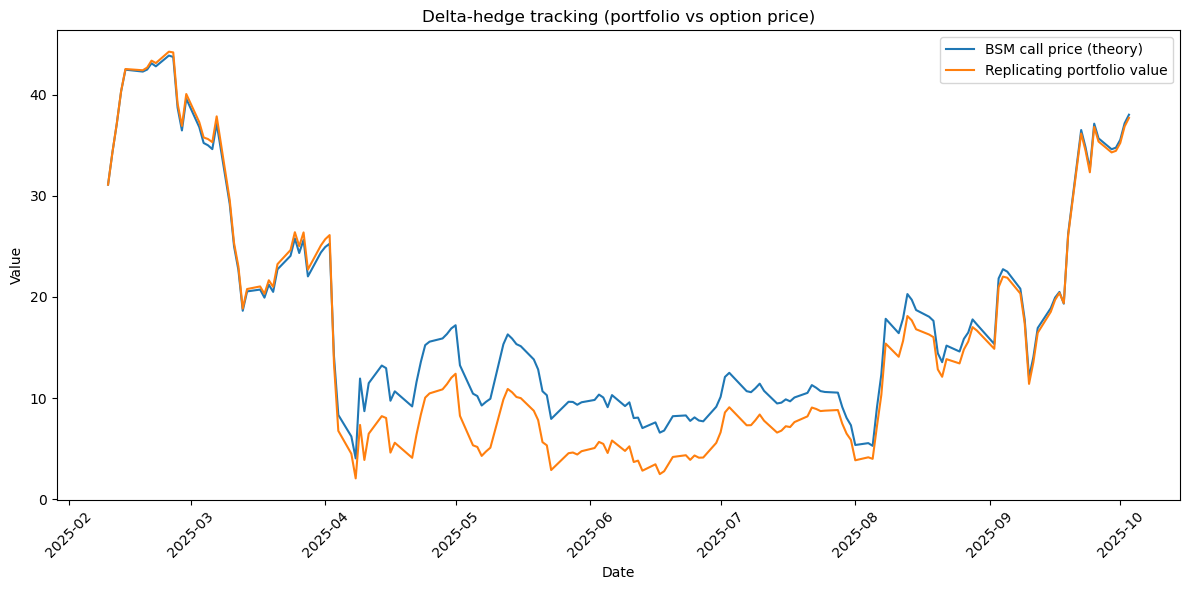

In [23]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

underlying = "AAPL"
K = 220.0
expiry = pd.Timestamp('2025-10-03')  # дата экспирации
trade_start = pd.Timestamp('2025-02-10')  # дата старта сделки
r = 0.05  # непрерывная безрисковая ставка (можно скорректировать)
trading_days_per_year = 252
dt = 1.0 / trading_days_per_year
grow = np.exp(r * dt)

df = pd.read_csv('data/AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

rv_start = pd.Timestamp('2025-01-10')
rv_end_exclusive = trade_start  # до даты старта сделки, не включая её

mask_rv = (df['Date'] >= rv_start) & (df['Date'] < rv_end_exclusive)
window = df.loc[mask_rv, ['Date', 'underlyingPrice']].copy()

if window.empty or window['underlyingPrice'].isna().all():
    raise ValueError("Нет достаточных данных для расчёта реализованной волатильности в окне 2025-01-10..2025-02-09.")

window['log_price'] = np.log(window['underlyingPrice'])
log_rets = window['log_price'].diff().dropna()

daily_vol = log_rets.std(ddof=1)
sigma_realized = float(daily_vol * np.sqrt(trading_days_per_year))
# На всякий случай ограничим минимальный уровень для численной устойчивости
sigma_realized = max(sigma_realized, 1e-8)

mask_trading = (df['Date'] >= trade_start) & (df['Date'] <= expiry)
path = df.loc[mask_trading, ['Date', 'underlyingPrice']].reset_index(drop=True)
if path.empty:
    raise ValueError("Нет цен между датой старта и экспирацией в файле.")

dates = path['Date'].to_numpy()
S = path['underlyingPrice'].to_numpy(dtype=float)

# время до экспирации T_t (ACT/252 по торговым дням из файла)
all_dates_for_T = df.loc[df['Date'] <= expiry, 'Date'].to_numpy()
index_map = {d: i for i, d in enumerate(all_dates_for_T)}
last_idx = index_map[expiry]
idxs = np.array([index_map[d] for d in dates])
days_left = last_idx - idxs
T = days_left / trading_days_per_year

sigma = sigma_realized

# Инициализация реплицирующего портфеля (самофинансируемый)
S0, T0 = S[0], T[0]
C0 = float(PVCallBS(S0, K, T0, r, sigma))
Delta0 = float(DeltaCallBS(S0, K, T0, r, sigma))

Delta = np.empty_like(S)
B = np.empty_like(S)
V = np.empty_like(S)

Delta[0] = Delta0
B[0] = C0 - Delta0 * S0
V[0] = Delta[0] * S0 + B[0]  # == C0

# Ежедневная самофинансируемая ребалансировка
for t in range(len(S) - 1):
    # проценты на кэш
    B[t] *= grow
    # новая дельта на t+1 (используем твою DeltaCallBS)
    Delta_next = float(DeltaCallBS(S[t + 1], K, T[t + 1], r, sigma))
    dDelta = Delta_next - Delta[t]
    # покупка/продажа акций по цене S_{t+1}
    B[t + 1] = B[t] - dDelta * S[t + 1]
    Delta[t + 1] = Delta_next
    # стоимость портфеля
    V[t + 1] = Delta[t + 1] * S[t + 1] + B[t + 1]

# Выплата и финрезультат
payoff_T = max(S[-1] - K, 0.0)
V_T = V[-1]
hedge_error = V_T - payoff_T

print("=== Self-financing Delta-Hedging Result (AAPL) ===")
print(f"Strike K: {K}")
print(f"Expiry: {expiry.date()} | Trade start: {trade_start.date()}")
print(f"Risk-free rate r (cont.): {r:.4f}")
print(f"Realized volatility used (annualized): {sigma:.6f}")
print(f"Initial spot S0: {S0:.4f} | Initial T (years): {T0:.6f}")
print(f"Initial option price C0 (BSM): {C0:.6f}")
print(f"Initial Delta: {Delta0:.6f}")
print(f"Final spot ST: {S[-1]:.4f} | Option payoff: {payoff_T:.6f}")
print(f"Final portfolio value V_T: {V_T:.6f}")
print(f"Hedging P&L (V_T - payoff): {hedge_error:.6f}")

# Графики
# Путь портфеля vs теоретическая цена опциона (используем PVCallBS поэлементно, т.к. T — массив)
C_series = np.array([float(PVCallBS(S[i], K, T[i], r, sigma)) for i in range(len(S))])

plt.figure(figsize=(12, 6))
plt.plot(dates, C_series, label='BSM call price (theory)')
plt.plot(dates, V, label='Replicating portfolio value')
plt.title('Delta-hedge tracking (portfolio vs option price)')
plt.xlabel('Date');
plt.ylabel('Value')
plt.xticks(rotation=45);
plt.legend();
plt.tight_layout();
plt.show()

3. Plot the time evolution of the financial result.

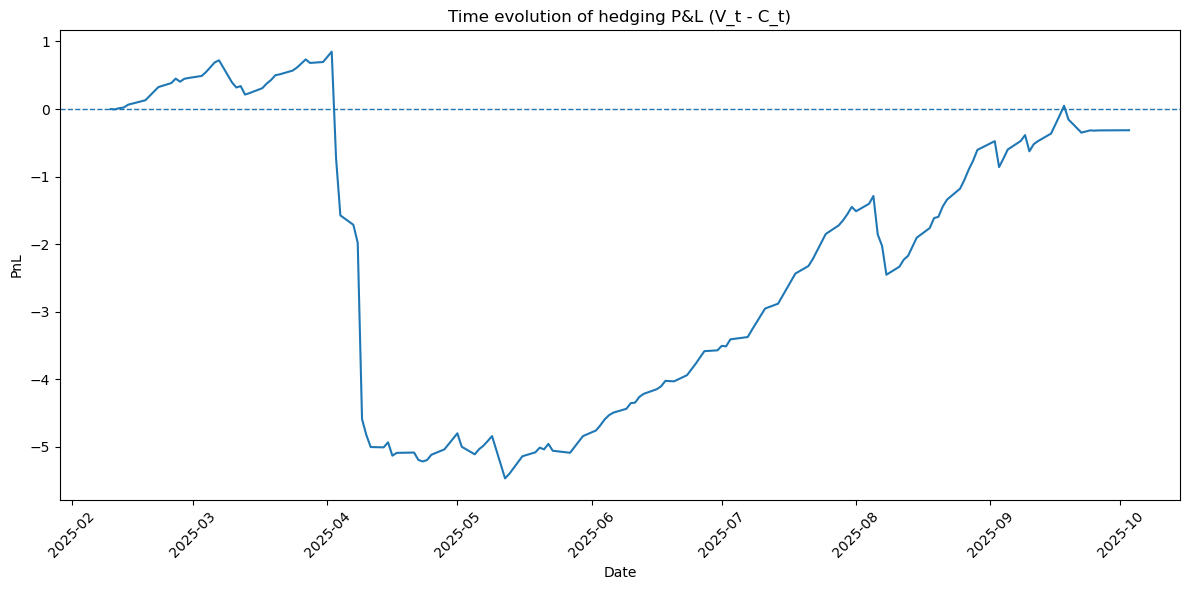

Final hedging PnL from series: -0.313555 (should equal V_T - payoff)


In [24]:
# Эволюция результата хеджа во времени: PnL_t = V_t - C_t
pnl_series = V - C_series
plt.figure(figsize=(12, 6))
plt.plot(dates, pnl_series)
plt.axhline(0.0, linestyle='--', linewidth=1)
plt.title('Time evolution of hedging P&L (V_t - C_t)')
plt.xlabel('Date');
plt.ylabel('PnL')
plt.xticks(rotation=45);
plt.tight_layout();
plt.show()

print(f"Final hedging PnL from series: {pnl_series[-1]:.6f} (should equal V_T - payoff)")

# Task 3: Thinking - 3 points

1. Assume we take constant volatility parameter with value equal 0.5.
Decompose the hedging error into components. Plot the results.
Explain sign of each component and factors affecting its size.

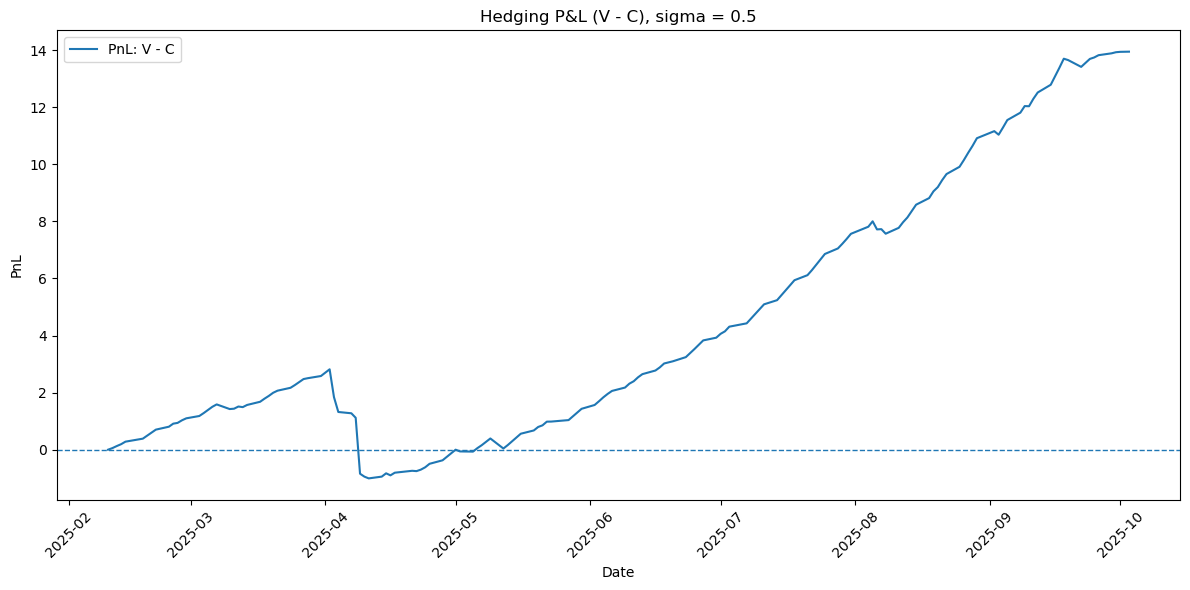

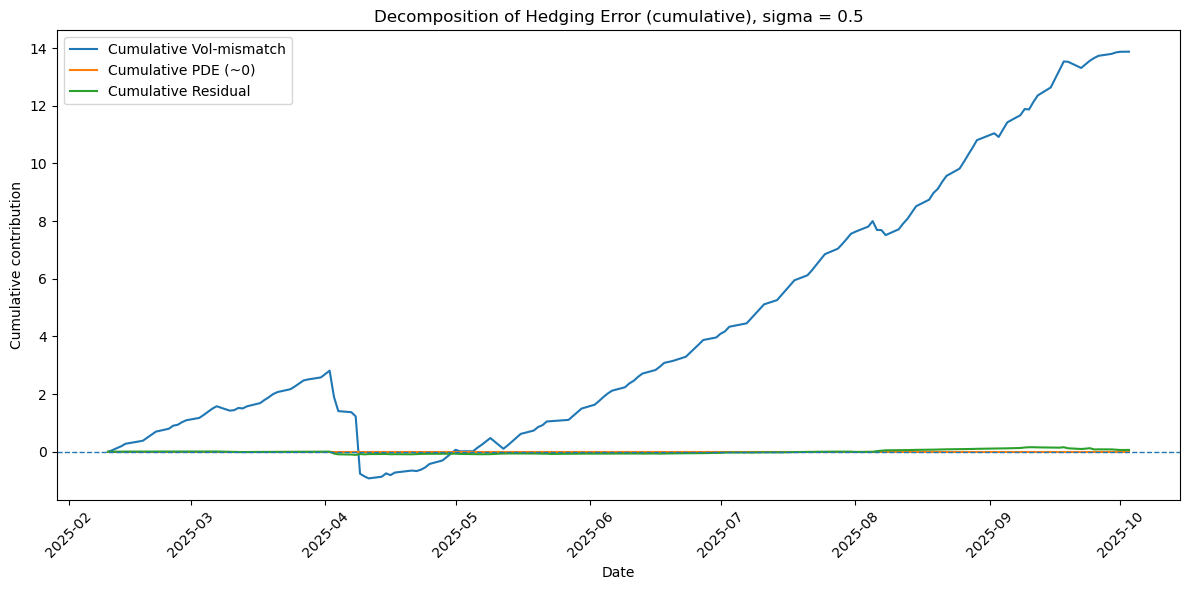

Final PnL (V_T - C_T): 13.942447691132088
Sum of components (final): 13.942447691132084
Max abs diff between PnL and sum of components: 3.552713678800501e-15


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sigma_model = 0.5  # по условию

if 'df' not in globals():
    try:
        df = pd.read_csv('data/AAPL.csv')
    except FileNotFoundError:
        df = pd.read_csv('AAPL.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
else:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

# торговой путь
mask = (df['Date'] >= trade_start) & (df['Date'] <= expiry)
path = df.loc[mask, ['Date', 'underlyingPrice']].reset_index(drop=True)
if path.empty:
    raise ValueError("Нет данных в окне хеджа.")

dates = path['Date'].to_numpy()
S = path['underlyingPrice'].to_numpy(dtype=float)

# время до экспирации T_t (ACT/252 по торговым дням из файла)
all_dates = df.loc[df['Date'] <= expiry, 'Date'].to_numpy()
index_map = {d: i for i, d in enumerate(all_dates)}
last_idx = index_map[expiry]
idxs = np.array([index_map[d] for d in dates])
days_left = last_idx - idxs
T = days_left / trading_days_per_year

# используем твои функции (поэлементно, т.к. T скалярно ожидается)
C = np.array([float(PVCallBS(S[i], K, float(T[i]), r, sigma_model)) for i in range(len(S))])
Delta = np.array([float(DeltaCallBS(S[i], K, float(T[i]), r, sigma_model)) for i in range(len(S))])
Gamma = np.array([float(GammaBS(S[i], K, float(T[i]), r, sigma_model)) for i in range(len(S))])

# Theta через PDE (годовой): Θ = r*C - r*S*Delta - 0.5*σ^2*S^2*Gamma
Theta = r * C - r * S * Delta - 0.5 * (sigma_model ** 2) * (S ** 2) * Gamma

# самофинансируемый портфель (дельта-хедж)
B = np.empty_like(S)
V = np.empty_like(S)
V[0] = C[0]
B[0] = V[0] - Delta[0] * S[0]

grow = np.exp(r * dt)
for t in range(len(S) - 1):
    B[t] *= grow
    dDelta = Delta[t + 1] - Delta[t]
    B[t + 1] = B[t] - dDelta * S[t + 1]
    V[t + 1] = Delta[t + 1] * S[t + 1] + B[t + 1]

# приращения и декомпозиция
dS = np.diff(S)
dPnL = (V[1:] - C[1:]) - (V[:-1] - C[:-1])  # d(V - C)

# Vol-mismatch (вар-разница): 0.5*Γ*((σ^2 S^2 dt) - (ΔS)^2)
vol_comp = 0.5 * Gamma[:-1] * ((sigma_model ** 2) * (S[:-1] ** 2) * dt - (dS ** 2))

# PDE-компонент (≈ 0 в непрерывном BSM):
pde_comp = (Theta[:-1] + 0.5 * (sigma_model ** 2) * (S[:-1] ** 2) * Gamma[:-1] - r * (
        C[:-1] - S[:-1] * Delta[:-1])) * dt

# Остаток (дискретный хедж и высокие порядки)
residual = dPnL - vol_comp - pde_comp

# кумулятивные суммы (должны сложиться в PnL_t)
cum_vol = np.concatenate([[0.0], np.cumsum(vol_comp)])
cum_pde = np.concatenate([[0.0], np.cumsum(pde_comp)])
cum_res = np.concatenate([[0.0], np.cumsum(residual)])
pnl_series = V - C

# графики
plt.figure(figsize=(12, 6))
plt.plot(dates, pnl_series, label='PnL: V - C')
plt.axhline(0.0, linestyle='--', linewidth=1)
plt.title('Hedging P&L (V - C), sigma = 0.5')
plt.xlabel('Date');
plt.ylabel('PnL');
plt.xticks(rotation=45);
plt.legend()
plt.tight_layout();
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(dates, cum_vol, label='Cumulative Vol-mismatch')
plt.plot(dates, cum_pde, label='Cumulative PDE (~0)')
plt.plot(dates, cum_res, label='Cumulative Residual')
plt.axhline(0.0, linestyle='--', linewidth=1)
plt.title('Decomposition of Hedging Error (cumulative), sigma = 0.5')
plt.xlabel('Date');
plt.ylabel('Cumulative contribution');
plt.xticks(rotation=45);
plt.legend()
plt.tight_layout();
plt.show()

# контроль согласования
check = cum_vol + cum_pde + cum_res
print("Final PnL (V_T - C_T):", float(pnl_series[-1]))
print("Sum of components (final):", float(check[-1]))
print("Max abs diff between PnL and sum of components:",
      float(np.max(np.abs(pnl_series - check))))

In [32]:
finals = {
    "Variance": cum_vol[-1],
    "PDE": cum_pde[-1],
    "Residual": cum_res[-1],
    "Total PnL": (V[-1] - C[-1])
}
total = finals["Total PnL"]
for k in ["Variance", "PDE", "Residual", "Total PnL"]:
    val = finals[k]
    pct = (val / total * 100) if total != 0 and k != "Total PnL" else None
    print(f"{k:9s}: {val: .6f}")

Variance :  13.879513
PDE      : -0.000000
Residual :  0.062934
Total PnL:  13.942448


2. Assume we recalibrate the volatility parameter in the model to match the implied volatility obtained from the market for the corresponding sold call option, with these values located in the "impliedVolatility" column of the data table.
Decompose the hedging error into components. Plot the results.
Explain sign of each component and factors affecting its size.

Final PnL (V_T - C_T): -1.870165764326856
Sum of components (final): -1.8701657643268583
Max abs diff between PnL and sum of components: 3.1086244689504383e-15


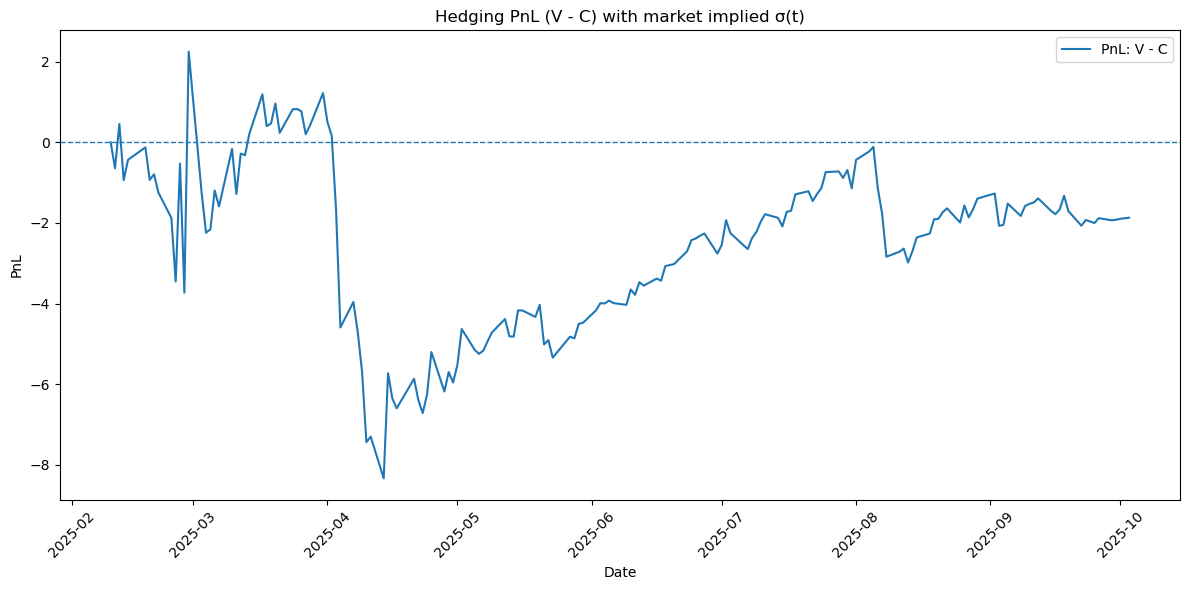

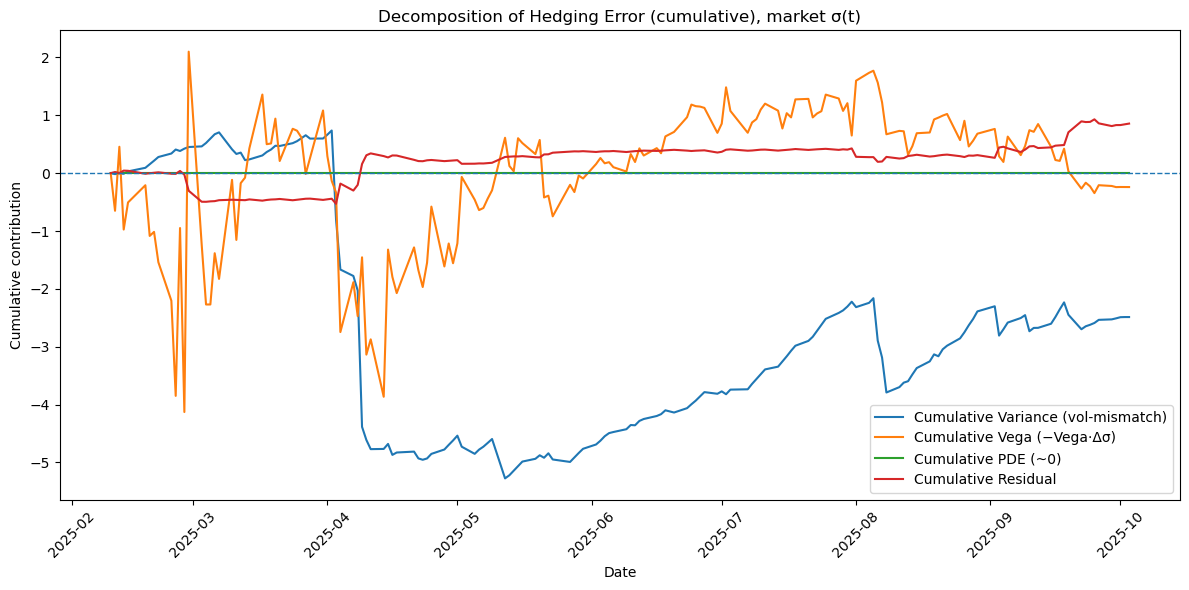

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

K = 220.0
expiry = pd.Timestamp('2025-10-03')
trade_start = pd.Timestamp('2025-02-10')
r = 0.05

# подгрузка данных, если нужно
if 'df' not in globals():
    try:
        df = pd.read_csv('data/AAPL.csv')
    except FileNotFoundError:
        df = pd.read_csv('AAPL.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

if 'impliedVolatility' not in df.columns:
    raise ValueError("В таблице нет столбца 'impliedVolatility'.")

# отрезок торговли
mask = (df['Date'] >= trade_start) & (df['Date'] <= expiry)
path = df.loc[mask, ['Date', 'underlyingPrice', 'impliedVolatility']].reset_index(drop=True)
if path.empty:
    raise ValueError("Нет данных в окне хеджа.")

dates = path['Date'].to_numpy()
S = path['underlyingPrice'].to_numpy(float)

# время до экспирации T_t (ACT/252 по торговым дням в файле)
trading_days_per_year = 252
all_dates = df.loc[df['Date'] <= expiry, 'Date'].to_numpy()
index_map = {d: i for i, d in enumerate(all_dates)}
last_idx = index_map[expiry]
idxs = np.array([index_map[d] for d in dates])
days_left = last_idx - idxs
T = days_left / trading_days_per_year

# robust-предобработка implied vol
sigma_raw = path['impliedVolatility'].astype(float).to_numpy()

if np.nanmedian(sigma_raw) > 3:
    sigma_raw = sigma_raw / 100.0

# ffill/bfill пропусков внутри окна
sigma_series = pd.Series(sigma_raw).replace([np.inf, -np.inf], np.nan).ffill().bfill().to_numpy()

# численная «санитария»: отсечь невалидные и экстремальные значения
sigma_series = np.clip(sigma_series, 1e-6, 5.0)

# финальная проверка
if np.isnan(sigma_series).any():
    raise ValueError("После очистки всё ещё есть NaN в impliedVolatility внутри окна хеджа.")

C = np.array([float(PVCallBS(S[i], K, float(T[i]), r, float(sigma_series[i]))) for i in range(len(S))])
Delta = np.array([float(DeltaCallBS(S[i], K, float(T[i]), r, float(sigma_series[i]))) for i in range(len(S))])
Gamma = np.array([float(GammaBS(S[i], K, float(T[i]), r, float(sigma_series[i]))) for i in range(len(S))])
Vega = np.array([float(VegaBS(S[i], K, float(T[i]), r, float(sigma_series[i]))) for i in range(len(S))])

assert not np.isnan(C).any(), "NaN в C после расчёта"
assert not np.isnan(Delta).any(), "NaN в Delta после расчёта"
assert not np.isnan(Gamma).any(), "NaN в Gamma после расчёта"
assert not np.isnan(Vega).any(), "NaN в Vega после расчёта"

# самофинансируемый дельта-хедж (проценты по ACT/365 между датами)
# шаги по календарным дням:
dt_array = np.diff(dates).astype('timedelta64[D]').astype(int) / 365.0
grow_steps = np.exp(r * dt_array)

B = np.empty_like(S);
V = np.empty_like(S)
V[0] = C[0]
B[0] = V[0] - Delta[0] * S[0]

for t in range(len(S) - 1):
    B[t] *= grow_steps[t]
    dDelta = Delta[t + 1] - Delta[t]
    B[t + 1] = B[t] - dDelta * S[t + 1]
    V[t + 1] = Delta[t + 1] * S[t + 1] + B[t + 1]

# приращения и декомпозиция
dS = np.diff(S)
dσ = np.diff(sigma_series)
dPnL = (V[1:] - C[1:]) - (V[:-1] - C[:-1])  # d(V - C)

# компоненты:
# Variance (vol-mismatch): 0.5*Γ*((σ_t^2 S_t^2 dt) - (ΔS_t)^2)
# здесь dt берём торговый шаг 1/252 — так же, как в классической дискретизации вариации
dt_trading = 1.0 / trading_days_per_year
vol_comp = 0.5 * Gamma[:-1] * ((sigma_series[:-1] ** 2) * (S[:-1] ** 2) * dt_trading - (dS ** 2))

# Vega (implied move): - Vega_t * Δσ_t
vega_comp = - Vega[:-1] * dσ

# PDE (~0 в непрерывном BSM):
Theta = r * C - r * S * Delta - 0.5 * (sigma_series ** 2) * (S ** 2) * Gamma  # годовой
pde_comp = (Theta[:-1] + 0.5 * (sigma_series[:-1] ** 2) * (S[:-1] ** 2) * Gamma[:-1] - r * (
        C[:-1] - S[:-1] * Delta[:-1])) * dt_trading

# Остаток
residual = dPnL - vol_comp - vega_comp - pde_comp

# кумулятивные суммы и проверки
cum_vol = np.concatenate([[0.0], np.cumsum(vol_comp)])
cum_vega = np.concatenate([[0.0], np.cumsum(vega_comp)])
cum_pde = np.concatenate([[0.0], np.cumsum(pde_comp)])
cum_res = np.concatenate([[0.0], np.cumsum(residual)])
pnl_series = V - C
check = cum_vol + cum_vega + cum_pde + cum_res

print("Final PnL (V_T - C_T):", float(pnl_series[-1]))
print("Sum of components (final):", float(check[-1]))
print("Max abs diff between PnL and sum of components:",
      float(np.max(np.abs(pnl_series - check))))

# графики
plt.figure(figsize=(12, 6))
plt.plot(dates, pnl_series, label='PnL: V - C')
plt.axhline(0.0, linestyle='--', linewidth=1)
plt.title('Hedging PnL (V - C) with market implied σ(t)')
plt.xlabel('Date');
plt.ylabel('PnL');
plt.xticks(rotation=45);
plt.legend()
plt.tight_layout();
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(dates, cum_vol, label='Cumulative Variance (vol-mismatch)')
plt.plot(dates, cum_vega, label='Cumulative Vega (−Vega·Δσ)')
plt.plot(dates, cum_pde, label='Cumulative PDE (~0)')
plt.plot(dates, cum_res, label='Cumulative Residual')
plt.axhline(0.0, linestyle='--', linewidth=1)
plt.title('Decomposition of Hedging Error (cumulative), market σ(t)')
plt.xlabel('Date');
plt.ylabel('Cumulative contribution');
plt.xticks(rotation=45);
plt.legend()
plt.tight_layout();
plt.show()

In [34]:
finals = {
    "Variance": cum_vol[-1],
    "Vega": cum_vega[-1],
    "PDE": cum_pde[-1],
    "Residual": cum_res[-1],
    "Total PnL": (V[-1] - C[-1])
}
total = finals["Total PnL"]
for k in ["Variance", "Vega", "PDE", "Residual", "Total PnL"]:
    val = finals[k]
    pct = (val / total * 100) if total != 0 and k != "Total PnL" else None
    print(f"{k:9s}: {val: .6f}")

Variance : -2.486783
Vega     : -0.240194
PDE      : -0.000000
Residual :  0.856811
Total PnL: -1.870166


Итоговый PnL отрицательный, значит к экспирации стоимость хедж-портфеля оказалась ниже стоимости обязательства по проданному коллу. Variance-компонента меняет знак в зависимости от того, выше или ниже оказалась фактическая дневная вариация цены по сравнению с модельной, при положительной гамме у колла. Когда рынок двигается спокойнее, чем подразумевает текущая волатильность, variance-вклад положительный; при сильных ходах и гэпах он становится отрицательным. По величине variance-компонента растет с гаммой (максимальна около денег и при большей волатильности), с размером дневного движения цены и при редкой ребалансировке. Vega-компонента равна минус вега умножить на изменение волатильности, поэтому при росте волатильности дает отрицательный вклад, а при падении — положительный. Размер vega-компоненты определяется уровнем веги (больше при большем времени до экспирации и около денег) и амплитудой изменений оценочной волатильности по пути. PDE-компонента в непрерывной модели равна нулю, а в дискретном расчете остается только малый численный шум, поэтому ее кумулятивный вклад близок к нулю. Residual аккумулирует эффекты дискретного дельта-хеджа и высшие нелинейности, поэтому усиливается на трендах и резких скачках цены и уменьшается при более частой ребалансировке. В твоем запуске основной источник отрицательного результата — variance-часть на участках повышенной фактической вариации, дополненная отрицательными всплесками vega при ростах волатильности. Совпадение суммы компонент с итоговым PnL до машинной точности подтверждает корректность декомпозиции и интерпретации вкладов.

3. Assume we recalibrate the volatility parameter in the model using estimates derived from a GARCH(1,1) model calibrated on daily historical stock price, with these values located in the "instantaneousVolatility" column of the data table.
Decompose the hedging error into components. Plot the results.
Explain sign of each component and factors affecting its size.

Final PnL (V_T - C_T): -2.138482908709449
Sum of components (final): -2.1384829087094444
Max abs diff between PnL and sum of components: 5.329070518200751e-15


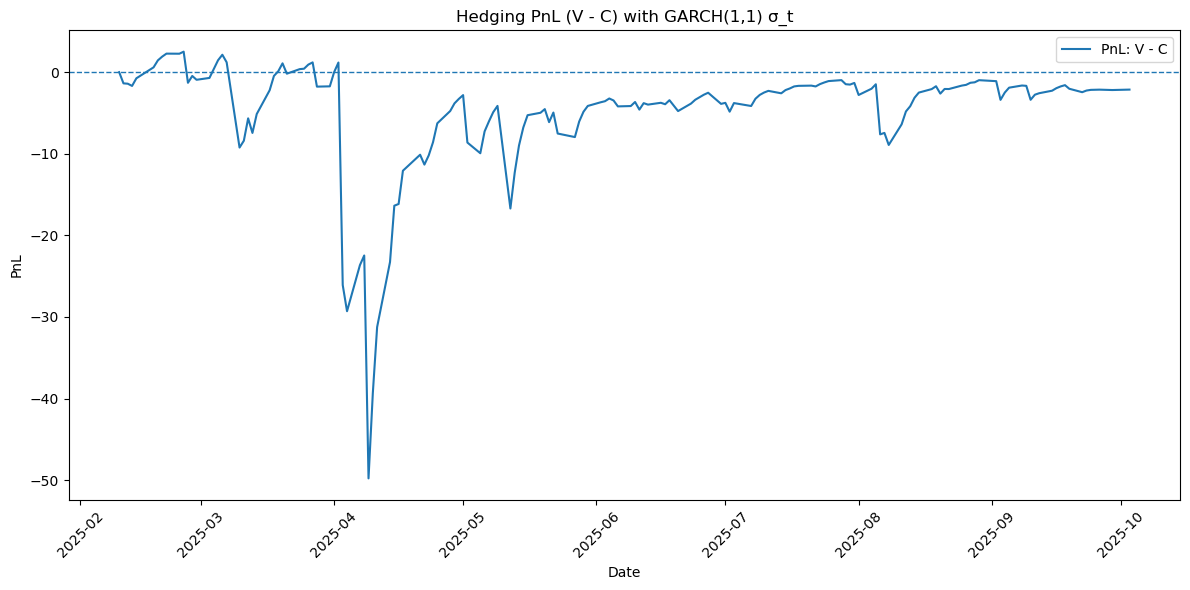

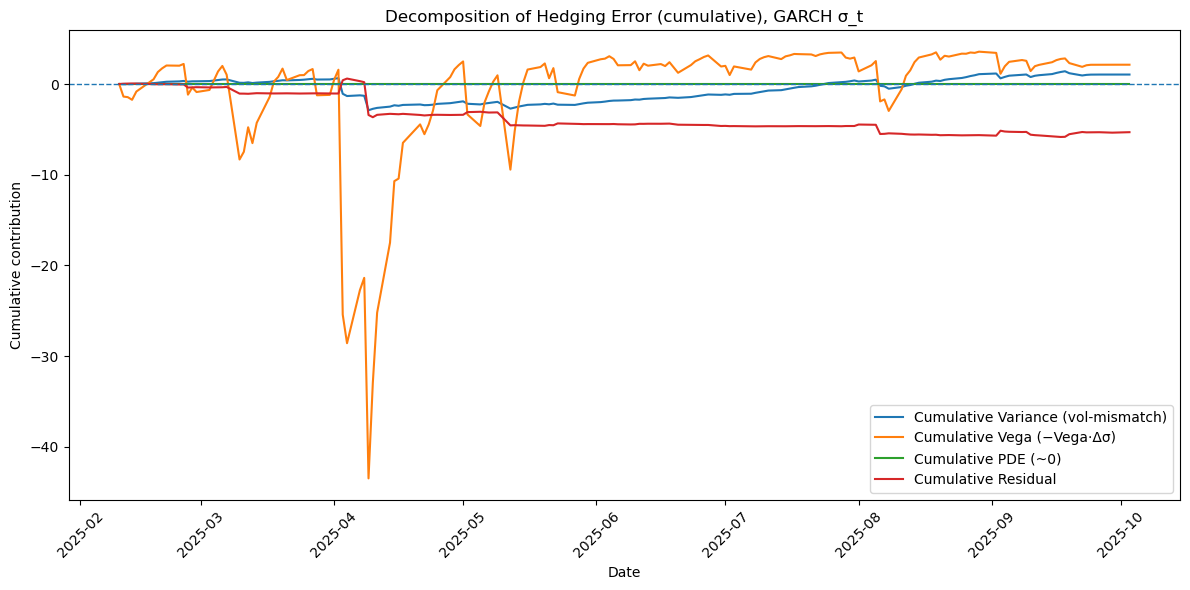

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

K = 220.0
expiry = pd.Timestamp('2025-10-03')
trade_start = pd.Timestamp('2025-02-10')
r = 0.05
trading_days_per_year = 252
dt_trading = 1.0 / trading_days_per_year

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

if 'instantaneousVolatility' not in df.columns:
    raise ValueError("В таблице нет столбца 'instantaneousVolatility'.")

mask = (df['Date'] >= trade_start) & (df['Date'] <= expiry)
path = df.loc[mask, ['Date', 'underlyingPrice', 'instantaneousVolatility']].reset_index(drop=True)
if path.empty:
    raise ValueError("Нет данных в окне хеджа.")

dates = path['Date'].to_numpy()
S = path['underlyingPrice'].to_numpy(float)

all_dates = df.loc[df['Date'] <= expiry, 'Date'].to_numpy()
index_map = {d: i for i, d in enumerate(all_dates)}
last_idx = index_map[expiry]
idxs = np.array([index_map[d] for d in dates])
days_left = last_idx - idxs
T = days_left / trading_days_per_year

# robust preprocessing for GARCH σ_t
sigma_raw = path['instantaneousVolatility'].astype(float).to_numpy()

# если столбец вдруг в процентах (например, 25 вместо 0.25) — делим на 100
if np.nanmedian(sigma_raw) > 3:
    sigma_raw = sigma_raw / 100.0

# ffill/bfill пропусков, отсечение экстремумов
sigma_series = (
    pd.Series(sigma_raw)
    .replace([np.inf, -np.inf], np.nan)
    .ffill().bfill()
    .to_numpy()
)
sigma_series = np.clip(sigma_series, 1e-6, 5.0)  # численная санитария
if np.isnan(sigma_series).any():
    raise ValueError("После очистки остались NaN в instantaneousVolatility.")

C = np.array([float(PVCallBS(S[i], K, float(T[i]), r, float(sigma_series[i]))) for i in range(len(S))])
Delta = np.array([float(DeltaCallBS(S[i], K, float(T[i]), r, float(sigma_series[i]))) for i in range(len(S))])
Gamma = np.array([float(GammaBS(S[i], K, float(T[i]), r, float(sigma_series[i]))) for i in range(len(S))])
Vega = np.array([float(VegaBS(S[i], K, float(T[i]), r, float(sigma_series[i]))) for i in range(len(S))])

dt_array_days = np.diff(dates).astype('timedelta64[D]').astype(int) / 365.0
grow_steps = np.exp(r * dt_array_days)

B = np.empty_like(S);
V = np.empty_like(S)
V[0] = C[0]
B[0] = V[0] - Delta[0] * S[0]

for t in range(len(S) - 1):
    B[t] *= grow_steps[t]
    dDelta = Delta[t + 1] - Delta[t]
    B[t + 1] = B[t] - dDelta * S[t + 1]
    V[t + 1] = Delta[t + 1] * S[t + 1] + B[t + 1]

dS = np.diff(S)
dσ = np.diff(sigma_series)
dPnL = (V[1:] - C[1:]) - (V[:-1] - C[:-1])  # d(V - C)

# Variance (vol-mismatch): 0.5*Gamma * (σ_t^2 S_t^2 dt - (ΔS_t)^2)
vol_comp = 0.5 * Gamma[:-1] * ((sigma_series[:-1] ** 2) * (S[:-1] ** 2) * dt_trading - (dS ** 2))

# Vega (implied-vol move under GARCH path): - Vega_t * Δσ_t
vega_comp = - Vega[:-1] * dσ

# PDE (~0 in continuous BSM):
Theta = r * C - r * S * Delta - 0.5 * (sigma_series ** 2) * (S ** 2) * Gamma  # annualized
pde_comp = (Theta[:-1] + 0.5 * (sigma_series[:-1] ** 2) * (S[:-1] ** 2) * Gamma[:-1] - r * (
        C[:-1] - S[:-1] * Delta[:-1])) * dt_trading

# Residual (discrete hedge & higher-order effects)
residual = dPnL - vol_comp - vega_comp - pde_comp

cum_vol = np.concatenate([[0.0], np.cumsum(vol_comp)])
cum_vega = np.concatenate([[0.0], np.cumsum(vega_comp)])
cum_pde = np.concatenate([[0.0], np.cumsum(pde_comp)])
cum_res = np.concatenate([[0.0], np.cumsum(residual)])
pnl_series = V - C
check = cum_vol + cum_vega + cum_pde + cum_res

print("Final PnL (V_T - C_T):", float(pnl_series[-1]))
print("Sum of components (final):", float(check[-1]))
print("Max abs diff between PnL and sum of components:",
      float(np.max(np.abs(pnl_series - check))))

plt.figure(figsize=(12, 6))
plt.plot(dates, pnl_series, label='PnL: V - C')
plt.axhline(0.0, linestyle='--', linewidth=1)
plt.title('Hedging PnL (V - C) with GARCH(1,1) σ_t')
plt.xlabel('Date');
plt.ylabel('PnL');
plt.xticks(rotation=45);
plt.legend()
plt.tight_layout();
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(dates, cum_vol, label='Cumulative Variance (vol-mismatch)')
plt.plot(dates, cum_vega, label='Cumulative Vega (−Vega·Δσ)')
plt.plot(dates, cum_pde, label='Cumulative PDE (~0)')
plt.plot(dates, cum_res, label='Cumulative Residual')
plt.axhline(0.0, linestyle='--', linewidth=1)
plt.title('Decomposition of Hedging Error (cumulative), GARCH σ_t')
plt.xlabel('Date');
plt.ylabel('Cumulative contribution');
plt.xticks(rotation=45);
plt.legend()
plt.tight_layout();
plt.show()

In [36]:
finals = {
    "Variance": cum_vol[-1],
    "Vega": cum_vega[-1],
    "PDE": cum_pde[-1],
    "Residual": cum_res[-1],
    "Total PnL": (V[-1] - C[-1])
}
total = finals["Total PnL"]
for k in ["Variance", "Vega", "PDE", "Residual", "Total PnL"]:
    val = finals[k]
    pct = (val / total * 100) if total != 0 and k != "Total PnL" else None
    print(f"{k:9s}: {val: .6f}")

Variance :  1.044071
Vega     :  2.127724
PDE      : -0.000000
Residual : -5.310278
Total PnL: -2.138483


Итог PnL (V_T − C_T) ≈ −2.14: к экспирации реплицирующий портфель оказался на ~2.14 ниже стоимости проданного колла (≈ −$214 на контракт с множителем 100). Сумма компонент совпадает с этим значением с машинной точностью (≈5e−15), значит декомпозиция корректно объясняет результат. На графике PnL по времени виден глубокий провал весной, затем медленное восстановление и новый зубец в августе: это типичный профиль short-gamma хеджа при резких движениях базового актива. На графике декомпозиции синяя кривая (Variance / vol-mismatch) — главный отрицательный вклад. Весной реализованная квадратичная вариация часто выше GARCH-прогноза. Летом рынок спокойнее, часть отыгрывается, но итог всё равно заметно отрицателен. Оранжевая (Vega = −Vega·Δσ) пилообразная: когда имплайд/GARCH-σ растёт ((Δσ>0)), цена опциона увеличивается (вега > 0), а (V−C) падает — отрицательный вклад; при падении σ — положительный. Итоговый знак этой кривой определяется суммой всех движений σ и размером веги. Зелёная (PDE) почти ноль по всему горизонту — так и должно быть: в непрерывной BSM эта часть тождественно равна нулю; у нас остаётся лишь численный шум дискретизации. Красная (Residual) объясняет остаток: дискретная перестановка дельты (особенно в трендовые дни и на гэпах), плюс высокие порядки (чарм/скорость, волга/ванна и т.д.). Она небольшая, но заметно реагирует в даты резких ходов.

Теперь про знаки:
   • Variance — определяется разницей модельной вариации vs реализованной: если рынок пилит меньше, чем прогнозирует σ_GARCH => плюс, если больше => минус.
   • Vega — (-\text{Vega}\cdot Δσ): (Δσ>0) => минус, (Δσ<0) => плюс.
   • PDE — ≈ 0.
   • Residual — может быть и плюс, и минус; на трендах и гэпах чаще минус для short-gamma.

   • Variance масштабируется гаммой и (|\Delta S|) (максимум около ATM и при большой σ), а также частотой ребаланса (реже ребаланс — больше ошибка).
   • Vega больше при большем T и около ATM и зависит от амплитуды Δσ по пути.
   • Residual растёт при редкой ребалансировке, длинных трендах, скачках цены и при больших расстояниях от ATM (из-за нелинейностей).
   • PDE — уменьшается при меньшем шаге по времени.

Даже с σ_t из GARCH(1,1) остаётся существенный variance-risk — модель прогнозирует среднюю вариацию, но отдельные всплески (весна/август) съедают PnL.